In [96]:
import gzip
import json
import re
import os
import sys
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from collections import defaultdict
import tensorflow as tf
import altair as alt
import collections

pd.set_option('display.max_colwidth', 100) 

from src.utils import split_dataframe, CFModel, book_neighbors
from src.load_data import read_tables
from src.DNN_Model import generate_dataset, build_dnn_model, make_shared_embedding_col, make_embedding_col

### load reviews and books data

In [25]:
reviews = pd.read_csv('data/cleaned_reviews_mystery_1.csv')
books = pd.read_csv('data/cleaned_books_mystery_1.csv')
books.sort_values(by='book_id', inplace=True)

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551765 entries, 0 to 1551764
Data columns (total 9 columns):
review_id      1551765 non-null object
user_id        1551765 non-null int64
book_id        1551765 non-null int64
rating         1551765 non-null int64
timestamp      1551765 non-null object
n_votes        1551765 non-null int64
n_comments     1551765 non-null int64
old_user_id    1551765 non-null object
old_book_id    1551765 non-null int64
dtypes: int64(6), object(3)
memory usage: 106.6+ MB


In [29]:
reviews.head(2)

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
0,d23dc89ab32cd864e54d18369751163b,102489,37120,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084
1,c7613da4cbd48baa83efec99b4dd6a41,102489,96299,3,2001-01-11 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,79030


In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105365 entries, 0 to 105364
Data columns (total 12 columns):
book_id               105365 non-null int64
title                 105365 non-null object
num_pages             105365 non-null int64
is_ebook              105365 non-null int64
link                  105365 non-null object
average_rating        105365 non-null float64
ratings_count         105365 non-null int64
text_reviews_count    105365 non-null int64
author_id             105365 non-null int64
publisher             76004 non-null object
similar_books         105365 non-null object
old_book_id           105365 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 9.6+ MB


In [30]:
books.head(2)

,book_id,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id
0,75512,The House of Memory (Pluto's Snitch #2),318,1,https://www.goodreads.com/book/show/33394837-t...,4.33,269,60,242185,NaN,[],33394837
1,35550,"Dead in the Morning (Patrick Grant, #1)",0,0,https://www.goodreads.com/book/show/1902202.De...,3.3,52,8,190988,Ulverscroft,[],1902202


### generate data for dnn model

input layer: previously liked book, previously disliked book, book content features (here only include 'author_id')

In [3]:
# one-time code to generate dataset for dnn model, then save to pickle file

# dataset = generate_dataset(reviews, books, min_good_rating =4, max_num_books_per_user=20) # processed 1551000 rows
#dataset.to_pickle('data/dnn_dataset_w_books.pkl')

In [30]:
# read saved dnn-ready data

dataset = pd.read_pickle('data/dnn_dataset_w_books.pkl')

In [15]:
dataset.tail(2)

,user_id,book_id,rating,timestamp,author_id,prev_good_books,prev_bad_books
1551763,34243,78523,5,2017-11-03 21:12:55,202905,"[55927, 47953, 44562, 61742, 68857, 55357, 606...",[]
1551764,71677,82113,3,2017-11-03 22:17:08,3936,"[46538, 83396, 13821]",[22731]


### build model

#### constraint to 2 previously liked and disliked books

    * author_id, no regularization
    * author_id, regularization
    * no author_id, no regularization
    * no author_id, regularization

In [31]:
#constraint to two previously liked and disliked books to speed up iteration

dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: x[:2])
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: x[:2])

* author_id, no regularization

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
build_dnn_model#4 calculate train/test loss
_train_init
_train_init done
 iteration 10000: train_loss=2.535836, test_loss=5.912593
time spent for the process is 159.62041 seconds


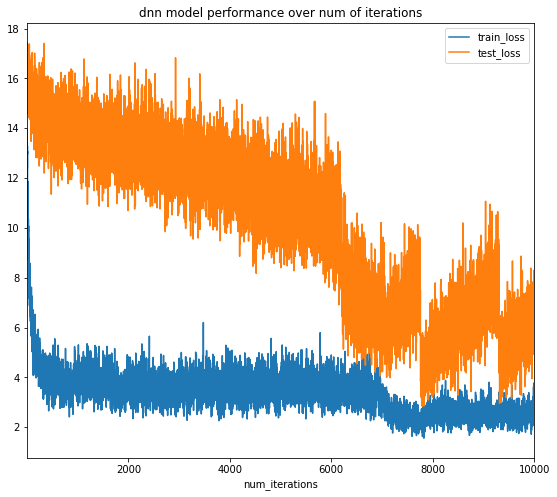

In [17]:
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_1 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    
start_time = timeit.default_timer()
dnn_model_1.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

In [19]:
dnn_model_1.embeddings

{'book_id': array([[-1.199591  , -0.20188786, -6.669064  ,  3.3778687 , -7.614459  ],
        [-3.7793665 , -9.343442  ,  2.5409143 , -7.077965  , -0.1314554 ],
        [ 9.907756  ,  6.331716  ,  4.065665  ,  2.0648074 ,  5.6550655 ],
        ...,
        [ 3.231779  , -2.5930002 ,  2.3235962 , -3.615927  , -3.650138  ],
        [-5.996556  , -4.0184255 ,  2.1403103 , -7.964383  , -5.136962  ],
        [ 4.3937187 , -1.2783953 ,  3.7339864 , -6.5928864 , -3.9058688 ]],
       dtype=float32)}

* author_id, regularization

In [ ]:
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_5 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1, regularization_coeff = 0.1
    )
    
start_time = timeit.default_timer()
dnn_model_5.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

* exclude author_id, with regularization = 0

In [ ]:
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) 
             # + [make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_4 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1, regularization_coeff = 0
    )
    
start_time = timeit.default_timer()
dnn_model_4.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
build_dnn_model#4 calculate train/test loss
_train_init
_train_init done
 iteration 1870: train_loss=4.512528, test_loss=12.354737

* exclude author_id, include regularization = 0.1

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
build_dnn_model#4 calculate train/test loss
_train_init
_train_init done
 iteration 10000: train_loss=4.885419, test_loss=9.217759
time spent for the process is 2177.42523 seconds


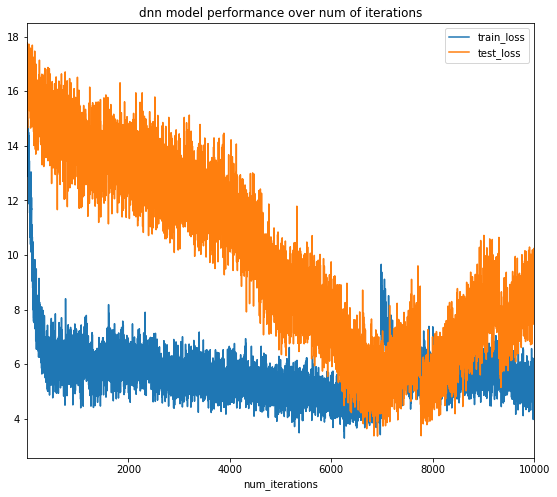

In [34]:
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) 
             # + [make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_3 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1, regularization_coeff = 0.1
    )
    
start_time = timeit.default_timer()
dnn_model_3.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

## get recommendations!

In [98]:
# get k recommendations by giving a title_substring of your favorate mystery/crime book

title_substring = 'Da Vinci Code'
k = 10
neighbors_df_1 = book_neighbors(books, dnn_model_1, title_substring, measure='cosine', k=k)

Nearest neighbors of : 98520    The Da Vinci Code (Robert Langdon, #2)
Name: title, dtype: object.


,cosine score,book_id,titles,average_rating,ratings_count,link
98520,0.9999998807907104,104081,"The Da Vinci Code (Robert Langdon, #2)",3.79,1465770,https://www.goodreads.com/book/show/968.The_Da_Vinci_Code
4769,0.9992167949676514,66347,The Black Tower,3.74,3059,https://www.goodreads.com/book/show/2942664-the-black-tower
56187,0.9974238872528076,62365,Dark Matter,4.1,75794,https://www.goodreads.com/book/show/27833670-dark-matter
34209,0.9967134594917297,88411,"Mortal Causes (Inspector Rebus, #6)",3.96,159,https://www.goodreads.com/book/show/634415.Mortal_Causes
16017,0.9966136813163757,96460,The Confession,3.81,42031,https://www.goodreads.com/book/show/7933437-the-confession
26165,0.9961009621620178,19343,"Transfer of Power (Mitch Rapp, #3)",4.31,31,https://www.goodreads.com/book/show/15800107-transfer-of-power
78927,0.9957641959190369,55874,15th Affair (Women's Murder Club #15),4.04,11813,https://www.goodreads.com/book/show/25613617-15th-affair
100903,0.9949195384979248,39500,Cold Cold Heart,3.85,46,https://www.goodreads.com/book/show/20792121-cold-cold-heart
94122,0.9948283433914185,23832,Consider Yourself Dead,3.67,116,https://www.goodreads.com/book/show/1672164.Consider_Yourself_Dead
30708,0.9945151805877686,61317,"Shaken (Struck, #3)",4.14,248,https://www.goodreads.com/book/show/27254713-shaken


In [64]:
# get the hyper link to the n-th nearest neighbor

n=0

neighbors_df_1.sort_values(['cosine score'], ascending=False).iloc[n]

cosine score                                             0.9999998807907104
book_id                                                              104081
titles                               The Da Vinci Code (Robert Langdon, #2)
average_rating                                                         3.79
ratings_count                                                       1465770
link              https://www.goodreads.com/book/show/968.The_Da_Vinci_Code
Name: 98520, dtype: object

#### constraint to 5 previously liked and disliked books

In [20]:
# read saved dnn-ready data

dataset = pd.read_pickle('data/dnn_dataset_w_books.pkl')

In [21]:
# constraint to 5 previously liked and disliked books

dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: x[:5])
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: x[:5])

In [22]:
start_time = timeit.default_timer()
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model_2 = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
build_dnn_model#4 calculate train/test loss
_train_init
_train_init done

time spent for the process is 323.47810 seconds


 iteration 10000: train_loss=2.515635, test_loss=6.094658
time spent for the process is 573.14055 seconds


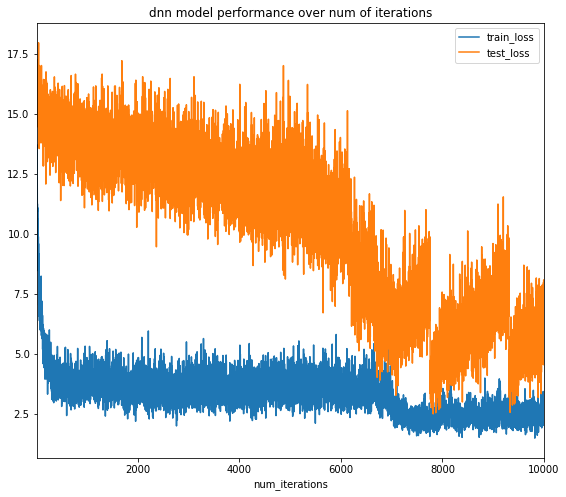

In [23]:
start_time = timeit.default_timer()
dnn_model_2.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

In [29]:
book_id = 104081
neighbors_df_2 = book_neighbors(books, dnn_model_2, book_id, measure='cosine', k=10)
neighbors_df_2.sort_values(['cosine score'], ascending=False)[:10]

Nearest neighbors of : The Da Vinci Code (Robert Langdon, #2).


,cosine score,book_id,titles,is_ebook,average_rating,ratings_count
98520,1.0,104081,"The Da Vinci Code (Robert Langdon, #2)",0,3.79,1465770
94416,0.9973840713500977,91271,Fear the Worst,0,3.87,67
17253,0.9968851804733276,9488,"All Necessary Force (Pike Logan, #2)",1,4.16,958
36713,0.9967859983444214,31087,Dark Paradise,0,3.06,41
65983,0.9964902997016907,30994,The Asylum,1,3.4,186
5370,0.9960483312606812,27912,"Fall Guy (Rachel Alexander & Dash, #7)",0,3.99,16
104980,0.9948335886001587,97249,"Pretty Little Liars (Pretty Little Liars, #1)",1,3.9,2533
33475,0.9948229193687439,16764,The Brotherhood of the Holy Shroud,0,3.48,2805
64570,0.9943198561668396,83373,"Void Moon (Harry Bosch Universe, #12)",0,3.95,314
78489,0.9938554763793945,96483,"The Reversal (Harry Bosch, #16; Mickey Haller,...",0,4.13,35649
